In [15]:
import pandas as pd
import numpy as np
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

### Creating a dummy data step to perform adaboost step by step | Manual step by step intuition code

In [5]:
df = pd.DataFrame()
df['X1'] = [1,2,3,4,5,6,6,7,9,9]
df['X2'] = [5,3,6,8,1,9,5,8,9,2]
df['label'] = [1,1,0,1,0,1,0,1,0,0]
df

,X1,X2,label
0,1,5,1
1,2,3,1
2,3,6,0
3,4,8,1
4,5,1,0
5,6,9,1
6,6,5,0
7,7,8,1
8,9,9,0
9,9,2,0


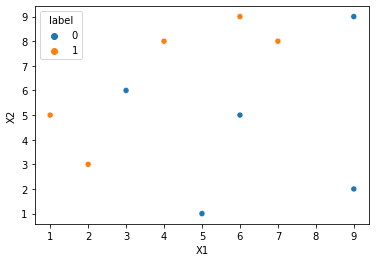

In [7]:
sns.scatterplot(x = df['X1'], y = df['X2'], hue = df['label'])

### Step by step code for adaboost

In [8]:
# Initializing the weights for rows which is 1/n where n is the number of rows
df['weights'] = 1/df.shape[0]
df

,X1,X2,label,weights
0,1,5,1,0.1
1,2,3,1,0.1
2,3,6,0,0.1
3,4,8,1,0.1
4,5,1,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1
7,7,8,1,0.1
8,9,9,0,0.1
9,9,2,0,0.1


In [10]:
# Creating the first decision stump as the first model in the boosting sequence
dt1 = DecisionTreeClassifier(max_depth = 1)

In [13]:
X = df.iloc[:,0:2].values
y = df.iloc[:,2].values
print(X)
print(y)

[[1 5]
 [2 3]
 [3 6]
 [4 8]
 [5 1]
 [6 9]
 [6 5]
 [7 8]
 [9 9]
 [9 2]]
[1 1 0 1 0 1 0 1 0 0]


[Text(0.5, 0.75, 'X[1] <= 2.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.75, 0.25, 'gini = 0.469\nsamples = 8\nvalue = [3, 5]')]

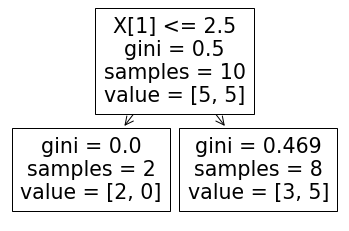

In [16]:
# training the first model and the plotting the decision stump
dt1.fit(X,y)
plot_tree(dt1)

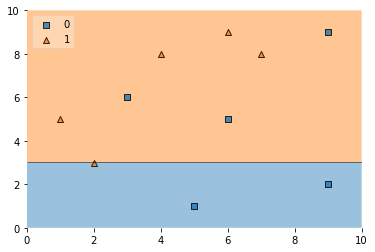

In [18]:
plot_decision_regions(X, y, clf = dt1, legend = 2)
# here we can see that there are approximately 3 errors from the first decision stump

In [19]:
df['y_pred'] = dt1.predict(X)
df

,X1,X2,label,weights,y_pred
0,1,5,1,0.1,1
1,2,3,1,0.1,1
2,3,6,0,0.1,1
3,4,8,1,0.1,1
4,5,1,0,0.1,0
5,6,9,1,0.1,1
6,6,5,0,0.1,1
7,7,8,1,0.1,1
8,9,9,0,0.1,1
9,9,2,0,0.1,0


### Defining the functions for calculating model weights and updating the row weights

In [33]:
def calculate_model_weight(error):
    return 0.5*np.log((1-error)/(error+0.000000000000000001))

#adding the small number in the denominator to avoid cases where error could be zero from a model

In [31]:
misclassified_count = df[((df['label']==1) & (df['y_pred']==0)) | ((df['label']==0) & (df['y_pred']==1))].shape[0]/df.shape[0]
print(misclassified_count)
alpha1 = calculate_model_weight(misclassified_count)
print(alpha1)

0.3
0.42364893019360184


In [34]:
def update_row_weights(row, alpha=0.423):
    if row['label'] == row['y_pred']:
        return row['weights'] * np.exp(-alpha)
    if row['label'] != row['y_pred']:
        return row['weights'] * np.exp(alpha)

In [32]:
df['updated_weights'] = df.apply(update_row_weights, axis = 1)
df

,X1,X2,label,weights,y_pred,updated_weights
0,1,5,1,0.1,1,0.065508
1,2,3,1,0.1,1,0.065508
2,3,6,0,0.1,1,0.152653
3,4,8,1,0.1,1,0.065508
4,5,1,0,0.1,0,0.065508
5,6,9,1,0.1,1,0.065508
6,6,5,0,0.1,1,0.152653
7,7,8,1,0.1,1,0.065508
8,9,9,0,0.1,1,0.152653
9,9,2,0,0.1,0,0.065508


In [36]:
df['updated_weights'].sum()

0.9165153319682015

In [35]:
df['normalized_weights'] = df['updated_weights']/df['updated_weights'].sum()
df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights
0,1,5,1,0.1,1,0.065508,0.071475
1,2,3,1,0.1,1,0.065508,0.071475
2,3,6,0,0.1,1,0.152653,0.166559
3,4,8,1,0.1,1,0.065508,0.071475
4,5,1,0,0.1,0,0.065508,0.071475
5,6,9,1,0.1,1,0.065508,0.071475
6,6,5,0,0.1,1,0.152653,0.166559
7,7,8,1,0.1,1,0.065508,0.071475
8,9,9,0,0.1,1,0.152653,0.166559
9,9,2,0,0.1,0,0.065508,0.071475


In [37]:
df['normalized_weights'].sum()

1.0

In [38]:
df['cumsum_upper'] = np.cumsum(df['normalized_weights'])
df['cumsum_lower'] = df['cumsum_upper'] - df['normalized_weights']
df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights,cumsum_upper,cumsum_lower
0,1,5,1,0.1,1,0.065508,0.071475,0.071475,0.000000
1,2,3,1,0.1,1,0.065508,0.071475,0.142950,0.071475
2,3,6,0,0.1,1,0.152653,0.166559,0.309508,0.142950
3,4,8,1,0.1,1,0.065508,0.071475,0.380983,0.309508
4,5,1,0,0.1,0,0.065508,0.071475,0.452458,0.380983
5,6,9,1,0.1,1,0.065508,0.071475,0.523933,0.452458
6,6,5,0,0.1,1,0.152653,0.166559,0.690492,0.523933
7,7,8,1,0.1,1,0.065508,0.071475,0.761967,0.690492
8,9,9,0,0.1,1,0.152653,0.166559,0.928525,0.761967
9,9,2,0,0.1,0,0.065508,0.071475,1.000000,0.928525


In [39]:
df.columns

Index(['X1', 'X2', 'label', 'weights', 'y_pred', 'updated_weights',
       'normalized_weights', 'cumsum_upper', 'cumsum_lower'],
      dtype='object')

### Now creating a new data set - upsampled one for the training of the next model which will focus on the errors made by the first model more.

In [50]:
def create_new_dataset(df):
    indices = []
    
    for i in range(df.shape[0]):
        a = np.random.random()
        for index, row in df.iterrows():
            if row['cumsum_upper'] > a and a > row['cumsum_lower']:
                indices.append(index)
    return indices

In [60]:
index_values = create_new_dataset(df)
index_values

[1, 6, 8, 8, 9, 8, 6, 6, 5, 6]

### Due to randomness, and the increased range, we are able to get duplicated rows for those rows where the predictions were wrong from the first model. This is upsampling. 

In [61]:
second_df = df.iloc[index_values, [0,1,2,3]]
second_df

,X1,X2,label,weights
1,2,3,1,0.1
6,6,5,0,0.1
8,9,9,0,0.1
8,9,9,0,0.1
9,9,2,0,0.1
8,9,9,0,0.1
6,6,5,0,0.1
6,6,5,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1


### Note: Since we already have upsampled the data, therefore weight initialization will again be like the initial one i.e. equal weights for each row.

[Text(0.5, 0.75, 'X[0] <= 4.0\ngini = 0.32\nsamples = 10\nvalue = [8, 2]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.75, 0.25, 'gini = 0.198\nsamples = 9\nvalue = [8, 1]')]

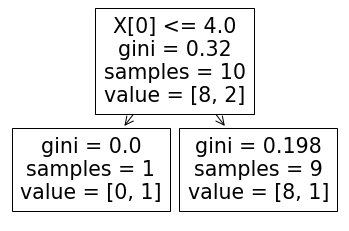

In [64]:
dt2 = DecisionTreeClassifier(max_depth = 1)
X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values
dt2.fit(X,y)
plot_tree(dt2)

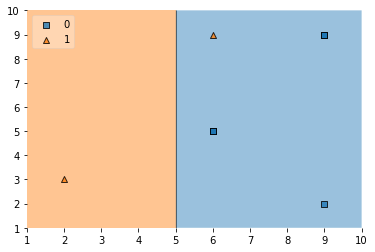

In [65]:
plot_decision_regions(X, y, clf = dt2, legend = 2)

In [66]:
second_df['y_pred'] = dt2.predict(X)
second_df

,X1,X2,label,weights,y_pred
1,2,3,1,0.1,1
6,6,5,0,0.1,0
8,9,9,0,0.1,0
8,9,9,0,0.1,0
9,9,2,0,0.1,0
8,9,9,0,0.1,0
6,6,5,0,0.1,0
6,6,5,0,0.1,0
5,6,9,1,0.1,0
6,6,5,0,0.1,0


In [68]:
misclassified_count_2 = second_df[((second_df['label']==1) & (second_df['y_pred']==0)) | ((second_df['label']==0) & (second_df['y_pred']==1))].shape[0]/second_df.shape[0]
print(misclassified_count_2)
alpha2 = calculate_model_weight(misclassified_count_2)
print(alpha2)

0.1
1.0986122886681098


In [69]:
def update_row_weights(row, alpha=alpha2):
    if row['label'] == row['y_pred']:
        return row['weights'] * np.exp(-alpha)
    if row['label'] != row['y_pred']:
        return row['weights'] * np.exp(alpha)

In [70]:
second_df['updated_weights'] = second_df.apply(update_row_weights, axis = 1)
second_df

,X1,X2,label,weights,y_pred,updated_weights
1,2,3,1,0.1,1,0.033333
6,6,5,0,0.1,0,0.033333
8,9,9,0,0.1,0,0.033333
8,9,9,0,0.1,0,0.033333
9,9,2,0,0.1,0,0.033333
8,9,9,0,0.1,0,0.033333
6,6,5,0,0.1,0,0.033333
6,6,5,0,0.1,0,0.033333
5,6,9,1,0.1,0,0.300000
6,6,5,0,0.1,0,0.033333


In [71]:
second_df['normalized_weights'] = second_df['updated_weights']/second_df['updated_weights'].sum()
second_df['cumsum_upper'] = np.cumsum(second_df['normalized_weights'])
second_df['cumsum_lower'] = second_df['cumsum_upper'] - second_df['normalized_weights']
second_df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights,cumsum_upper,cumsum_lower
1,2,3,1,0.1,1,0.033333,0.055556,0.055556,0.000000
6,6,5,0,0.1,0,0.033333,0.055556,0.111111,0.055556
8,9,9,0,0.1,0,0.033333,0.055556,0.166667,0.111111
8,9,9,0,0.1,0,0.033333,0.055556,0.222222,0.166667
9,9,2,0,0.1,0,0.033333,0.055556,0.277778,0.222222
8,9,9,0,0.1,0,0.033333,0.055556,0.333333,0.277778
6,6,5,0,0.1,0,0.033333,0.055556,0.388889,0.333333
6,6,5,0,0.1,0,0.033333,0.055556,0.444444,0.388889
5,6,9,1,0.1,0,0.300000,0.500000,0.944444,0.444444
6,6,5,0,0.1,0,0.033333,0.055556,1.000000,0.944444


In [72]:
index_values = create_new_dataset(second_df)
third_df = second_df.iloc[index_values, [0,1,2,3]]
third_df

,X1,X2,label,weights
6,6,5,0,0.1
8,9,9,0,0.1
8,9,9,0,0.1
6,6,5,0,0.1
6,6,5,0,0.1
8,9,9,0,0.1
5,6,9,1,0.1
8,9,9,0,0.1
8,9,9,0,0.1
6,6,5,0,0.1


[Text(0.5, 0.75, 'X[0] <= 7.5\ngini = 0.18\nsamples = 10\nvalue = [9, 1]'),
 Text(0.25, 0.25, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]')]

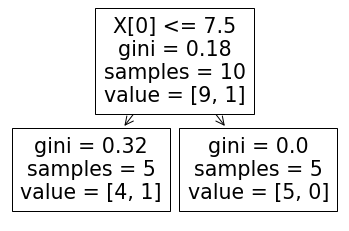

In [73]:
dt3 = DecisionTreeClassifier(max_depth = 1)
X = third_df.iloc[:,0:2].values
y = third_df.iloc[:,2].values
dt3.fit(X,y)
plot_tree(dt3)

/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


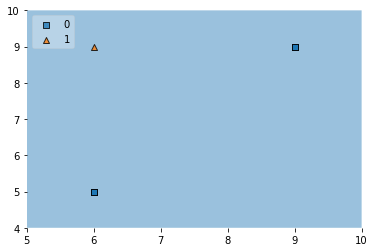

In [74]:
plot_decision_regions(X, y, clf = dt3, legend = 2)

In [75]:
third_df['y_pred'] = dt3.predict(X)
third_df

,X1,X2,label,weights,y_pred
6,6,5,0,0.1,0
8,9,9,0,0.1,0
8,9,9,0,0.1,0
6,6,5,0,0.1,0
6,6,5,0,0.1,0
8,9,9,0,0.1,0
5,6,9,1,0.1,0
8,9,9,0,0.1,0
8,9,9,0,0.1,0
6,6,5,0,0.1,0


In [76]:
alpha3 = calculate_model_weight(0.1)
alpha3

1.0986122886681098

In [79]:
print(alpha1, alpha2, alpha3)

0.42364893019360184 1.0986122886681098 1.0986122886681098


## Prediction

In [77]:
query = np.array([6,9]).reshape(1,2)
query

array([[6, 9]])

In [78]:
print(dt1.predict(query))
print(dt2.predict(query))
print(dt3.predict(query))

[1]
[0]
[0]


In [86]:
# instead of 0 for adaboost we have to put -1 as we use the sign funciton
np.sign(alpha1*1 +alpha2*(-1) + alpha3*(-1))
# This data point still have error from the ensemble as well

-1.0

In [81]:
query2 = np.array([6,5]).reshape(1,2)
query2

array([[6, 5]])

In [82]:
print(dt1.predict(query2))
print(dt2.predict(query2))
print(dt3.predict(query2))

[1]
[0]
[0]


In [83]:
# instead of 0 for adaboost we have to put -1 as we use the sign funciton
np.sign(alpha1*1 +alpha2*(-1) + alpha3*(-1))

-1.0

In [84]:
query3 = np.array([2,3]).reshape(1,2)
query3
print(dt1.predict(query3))
print(dt2.predict(query3))
print(dt3.predict(query3))

[1]
[1]
[0]


In [85]:
# instead of 0 for adaboost we have to put -1 as we use the sign funciton
np.sign(alpha1*1 +alpha2*(1) + alpha3*(-1))

1.0

### End